In [278]:
import numpy as np
import pickle
from numpy.linalg import norm


In [279]:
import os
print(os.listdir("."))
train_r = pickle.load(open("train_r.pkl", "rb"))
train_b = pickle.load(open("train_b.pkl", "rb"))
valid_r = pickle.load(open("valid_r.pkl", "rb"))
valid_b = pickle.load(open("valid_b.pkl", "rb"))

['train_b.pkl', 'CreateData.ipynb', 'train.pkl', 'valid_b.pkl', 'clean_real.txt', 'NativeBayes.ipynb', 'test_b.pkl', 'train_r.pkl', 'test_r.pkl', 'train.pickle', 'clean_fake.txt', 'LogisticRegression.ipynb', 'valid.pkl', 'valid_r.pkl', '.ipynb_checkpoints', 'test.pkl']


In [280]:
from sklearn.linear_model import LogisticRegression

In [281]:
lr = LogisticRegression()

In [282]:
print(valid_r[:3])

['trump and trade richardson every', 'trump charlottesville condemnation included neo nazis whitehouse', 'hameed darweesh iraqi refugee detained at jfk after trump order']


In [283]:
one_label = np.ones(len(train_r))
zeros_label = np.zeros(len(train_b))
one_test = np.ones(len(valid_r))
zero_test = np.zeros(len(valid_b))
trainX = np.concatenate((train_r, train_b))
trainY = np.concatenate((one_label, zeros_label))
validX = np.concatenate((valid_r, valid_b))
validY  = np.concatenate((one_test, zero_test))
print(validX[:3], len(validX))

['trump and trade richardson every'
 'trump charlottesville condemnation included neo nazis whitehouse'
 'hameed darweesh iraqi refugee detained at jfk after trump order'] 490


In [305]:
#gerenate feature vectors 
total_words = {}
for line in trainX:
    words = line.split(" ")
    for word in words:
        if word == "":
            continue
        try:
            total_words[word]
        except:
            total_words[word] = True

print(len(total_words.keys()))
#dont add words in valid and test sets

4818


In [307]:
#create training feats

#print(len(validX))
unique_keys = list(total_words.keys())
unique_keys.sort()
#print(unique_keys[:10])
#account for a bias
train_feats = np.zeros((len(trainX), len(total_words.keys()) ))
for i, line in enumerate(trainX):
    words = line.split(" ")
    #print(words)
    for word in words:
        if word =="":
            continue
        #print(unique_keys.index(word))
        ind = unique_keys.index(word)  
        #plus one is so that the very first is the bias (here a bias of zero)
        train_feats[i][ind] = 1


#create testing features
valid_feats = np.zeros((len(validX), len(total_words.keys())))
for i , line in enumerate(validX):
    words = line.split(" ")
    #print(len(words), end = " ")
    #if i ==0:
        #print(words)
    #print(words)
    for word in words:
        if word =="":
            continue
        #account for value error:
        try:
            ind = unique_keys.index(word) 
            #print(ind)
            valid_feats[i][ind] = 1
        except:
            continue       
#inds = np.where(valid_feats ==1)[1]
#print("\n", inds[:34])

In [308]:
#logistic regression model from assignment 1.
def grad_descent(f, df, x, y, reg, init_t, alpha, EPS=1e-4):
    print(reg)
    #EPS = 1e-4   #EPS = 10**(-5)
    prev_t = init_t-10*EPS
    t = init_t.copy()
    max_iter = 400
    iter  = 0
    while norm(t - prev_t) >  EPS and iter < max_iter:
        prev_t = t.copy()
        t -= alpha*df(x, y, t, reg)
        if iter % 50 == 0:
            print("Iter", iter)
        iter += 1
    print("Iter", iter)
    return t

In [309]:
#assume here that x is already flattened
def f(x, y, theta, reg):
    bias = np.ones( (1, x.shape[0])).T
    x = np.vstack( (bias.T, x.T))
    #print( np.sum(theta**2))
    return np.sum((y - np.dot(theta.T, x))**2) - reg*np.sum(theta**2)
    
def df(x, y, theta ,reg):
    bias = np.ones( (1, x.shape[0])).T
    x = np.vstack( (bias.T, x.T))
    #print( np.sum(theta) )
    return -2*np.sum((y-np.dot(theta.T, x))*x, 1) - 2.*reg*theta

In [310]:
np.random.seed(0)
#this is used to create the two differentn types of images, uncomment the one that you dont want
theta0 = np.random.random((len(unique_keys)+1))*5
theta0 = np.ones_like(theta0)

In [311]:
%%time
theta = grad_descent(f, df, train_feats, trainY,0.15,  theta0, 0.0001, EPS=5e-3)

0.15
Iter 0
Iter 50
Iter 100
Iter 150
Iter 200
Iter 250
Iter 300
Iter 350
Iter 400
CPU times: user 54.3 s, sys: 10.3 s, total: 1min 4s
Wall time: 32.4 s


In [312]:
#learning curve
valid_data_ones = np.concatenate((np.ones((1, valid_feats.shape[0])).T, valid_feats), axis = 1)
preds = np.dot( valid_data_ones, theta)
print(valid_data_ones.shape, theta.shape, preds.shape)
preds_binary= np.zeros_like(preds)
#preds_binary[preds<0.5] = 0
preds_binary[preds>0.5] = 1
#print(preds)
print(len(np.where(validY ==preds_binary)[0]), validY.shape[0])
print(len(np.where(validY ==preds_binary)[0])/ validY.shape[0])
#print(validY)

(490, 4819) (4819,) (490,)
242 490
0.49387755102040815


In [313]:
#logistic regression model from assignment 1.
def track_grad_descent(f, df, x, y,reg, init_t, alpha, EPS=1e-4):
    #EPS = 1e-4   #EPS = 10**(-5)
    prev_t = init_t-10*EPS
    t = init_t.copy()
    #times = np.linspace()
    max_iter = 1300
    iter  = 0
    thresh = 25
    iterations = np.arange(max_iter//thresh +1)*thresh
    learn_train = [0]#np.zeros_like(iterations)
    learn_valid = [0]#np.zeros_like(iterations)
    counter = 1
    while norm(t - prev_t) >  EPS and iter < max_iter:
        prev_t = t.copy()
        t -= alpha*df(x, y, t, reg)
        if iter % 500 == 0:
            print("Iter", iter)
        if (iter%thresh==thresh-1):
            #train scores
            train_data_ones = np.concatenate((np.ones((1, train_feats.shape[0])).T, train_feats), axis = 1)
            preds = np.dot(train_data_ones, prev_t)
            preds_binary= np.zeros_like(preds)
            preds_binary[preds<0.5] = 0
            preds_binary[preds>0.5] = 1
            val = len(np.where(trainY ==preds_binary)[0])/ float(trainY.shape[0])
            print(val)
            #print(learn_train[:], print(type(learn_train)))
            #print(learn_train, counter)
            #learn_train[:] = val
            learn_train.append(val)
            #learn_train = val
            #learn_train[0] = val
            #print(learn_train)
            
            #validationscores
            valid_data_ones = np.concatenate((np.ones((1, valid_feats.shape[0])).T, valid_feats), axis = 1)
            preds = np.dot( valid_data_ones, prev_t)
            preds_binary= np.zeros_like(preds)
            preds_binary[preds<0.5] = 0
            preds_binary[preds>0.5] = 1
            val =len(np.where(validY ==preds_binary)[0])/ float(validY.shape[0])
            print(val)
            learn_valid.append(val)
            #learn_valid[counter] = val
            #print(learn_valid)
            #counter +=1
            
        iter += 1
    print(learn_train, learn_valid)
    print("Iter", iter)
    return t, learn_train, learn_valid

In [314]:
%%time
np.random.seed(0)
theta0 = np.random.random((len(unique_keys)+1))
theta, train_learn, valid_learn = track_grad_descent(f, df, train_feats, trainY, 0.25, theta0, 0.0001, EPS=1e-4)

Iter 0
0.42369916921731526
0.4448979591836735
0.45999125491910803
0.47346938775510206
0.49365981635330125
0.46530612244897956
0.5080891998250984
0.49387755102040815
0.5212068211630958
0.49183673469387756
0.5373852208132925
0.5040816326530613
0.5544381285526891
0.5020408163265306
0.5658067337122868
0.5122448979591837
0.5767380848272846
0.5306122448979592
0.5859204197638828
0.5346938775510204
0.5959772627896808
0.536734693877551
0.6012243113248797
0.536734693877551
0.609969392216878
0.5448979591836735
0.6191517271534762
0.5469387755102041
0.6274595540008745
0.5489795918367347
0.6327066025360735
0.5428571428571428
0.6405771753388719
0.5387755102040817
0.6488850021862702
0.536734693877551
0.6541320507214692
0.5408163265306123
0.6624398775688675
0.5408163265306123
Iter 500
0.6694359422824662
0.5428571428571428
0.6773065150852645
0.5408163265306123
0.684739833843463
0.5448979591836735
0.6939221687800612
0.5469387755102041
0.6996064713598601
0.5469387755102041
0.7096633143856581
0.54693877551

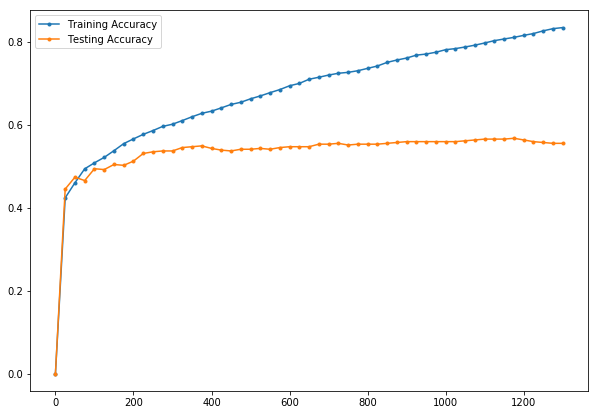

In [315]:
iterations = np.arange(1300//25 +1)*25
import matplotlib
from matplotlib import pyplot as plt
plt.figure(figsize = (10, 7))
plt.plot(iterations, train_learn, marker = ".", label = "Training Accuracy")
plt.plot(iterations, valid_learn, marker = ".", label = "Testing Accuracy")
plt.legend()
plt.show()
#print(train_learn)

#write up part 5

In [316]:
#part 6 in the code
print(theta)
#print the highest 10 vals, and include what they correspond to 
ordered_theta = theta.argsort()
lowest = ordered_theta[:10]
highest = ordered_theta[-10:]
print(highest[7:])
unique_keys = np.asarray(unique_keys)
print(unique_keys[lowest])
print(unique_keys[highest])
#edit code and see why do we have a null word?

[-0.87608463  0.67211309  0.56226197 ..., -0.07369296  0.09836016
  0.08750137]
[2093  164 2190]
['lead' 'begin' 'labels' 'sortie' '0' 'downgrades' 'young' 'trade' 'freak'
 '30']
['impression' 'pursuit' 'expert' 'taliban' 'serious' 'accepted' 'eclipse'
 'hung' 'africa' 'influencer']


In [323]:
#do this again, but remove stop words
#load the stop words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = list(ENGLISH_STOP_WORDS)
#print(stop_words)
counter = 0
new_low_words = []
for val in ordered_theta:
    if unique_keys[val] in stop_words:
        continue
    else:
        new_low_words.append(unique_keys[val])
    if len(new_low_words)>=10:
        break
print(new_low_words)


new_high_words = []
reversed_Words = np.flip(ordered_theta, axis = 0)
#print(reversed_Words[:10])
for val in reversed_Words:
    if unique_keys[val] in stop_words:
        continue
    else:
        new_high_words.append(unique_keys[val])
    if len(new_high_words)>=10:
        break
print(new_high_words)

['lead', 'begin', 'labels', 'sortie', '0', 'downgrades', 'young', 'trade', 'freak', '30']
['influencer', 'africa', 'hung', 'eclipse', 'accepted', 'taliban', 'expert', 'pursuit', 'impression', 'chuck']


Its reasonable to use magnitude for this, since the different scale for the features have meaning, if one is larger, it means that it occured more often(native bayes method)
For this one, the individual features are already normalized, since they're either zero if that word is not present, or are one if they are. 